# 6.Optimal Allocation of Charging Stations

## Import Packages

In [85]:
import pandas as pd
import numpy as np
import haversine as hs
from haversine import Unit 
import random
import sys
import math
import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from geopy.distance import great_circle
from scipy.spatial import distance
from pulp import *
import folium
from IPython.display import display

from folium import IFrame
from folium.plugins import MarkerCluster


import matplotlib.colors as mcolors
import contextily as ctx


## Import Data and Select sample
The goal was to collect Charging Demand Data based on taxi trip data by selecting trips from one exemplary day and sampling 10 percent from the current dataframe. Research presented several charging demand rates ranging from 10 to 40 percent based on underlying driving paterns. To reduce the problem complexity the already sampled dataframe is sampled a second time. Thus, in order to achieve completely accurate results, the whole demand data has to be loaded as an input to the optimization problem architecture. The calculated results will scale appropriately.

In [86]:
#read in cleaned dataframe
df = pd.read_parquet("../data/df_cleaned_21_08_2021.parquet")

In [87]:
#Select trip demand data of one day assuming that the demand distribution is comparable to other days
df_choosen_date = df[df['PU_DATE'].astype(str) == '2017-06-15']
df_sample_coordinates = df_choosen_date[['Dropoff Centroid Latitude','Dropoff Centroid Longitude']]
df_sample_coordinates.reset_index(drop = True, inplace = True)
df_sample_coordinates.rename(columns={"Dropoff Centroid Latitude": "lat_i", "Dropoff Centroid Longitude": "lon_i"},
                             inplace = True)
df_sample_coordinates.dropna(inplace=True)
print("Chosen df lenght: ",len(df_sample_coordinates))
df_coo = df_sample_coordinates.copy()


Chosen df lenght:  3679


In [88]:
#reducing dataframe
#make 10 percent sample based on the assumption that every tenth trip record presents a charging demand
def sampleFile(sample_size,df):
    df_new = df.sample(frac = (sample_size/100),random_state=42)
    return df_new

df_all= df.copy()
df_sample_coordinates = sampleFile(10,df_sample_coordinates)
print("New length of dataframe: ",len(df_sample_coordinates))
df_coo = df_sample_coordinates.copy()


New length of dataframe:  368


In [89]:
#transform to list
df_sample_coordinates = list(zip(df_sample_coordinates['lat_i'], df_sample_coordinates['lon_i']))
df_sample_coordinates

[(41.88415163193062, -87.64698224678236),
 (41.84083746872008, -87.62573913194683),
 (41.888943021728686, -87.63308398397615),
 (41.90060883207292, -87.62814878727613),
 (41.97710069106871, -87.64729399817952),
 (41.87894468266093, -87.64522592275242),
 (41.844794068010614, -87.63592832076445),
 (41.91684832967201, -87.68463107016329),
 (41.873526130809516, -87.60794872296732),
 (41.88456564150003, -87.66263518621429),
 (41.88872856337761, -87.59755016782148),
 (41.89644231347918, -87.63782859420103),
 (41.882068622275455, -87.62411919725285),
 (41.88790070326105, -87.62165109887326),
 (42.00008261702737, -87.91502810819239),
 (41.886233171210215, -87.61444083943978),
 (41.87790356810432, -87.63379557974066),
 (41.89415083644722, -87.63483937187699),
 (41.86519912320066, -87.62729962110843),
 (41.87894468266093, -87.64522592275242),
 (41.87852821984413, -87.62957437246672),
 (41.93748912767697, -87.65611510007965),
 (41.905394937318825, -87.66967121842745),
 (41.888733380624046, -87.65

## Prepare Demand & Charging Locations Data

### Read 15 parking locations as potential charging station locations

In [90]:
#Read identified exemplary potential spots for charging stations

#Coordinates from manually selected parking places
matrix_places = [(41.979924,-87.889203),(41.866892,-87.709123),(41.988964,-87.815256),(41.953126,-87.734401),(41.923712,-87.671640),(41.929753,-87.683072),(41.911702,-87.659789),(41.877352,-87.651294),(41.793872,-87.744691),(41.861232,-87.641932)
                ,(41.856649,-87.614369),(41.832767,-87.613840),(41.809059,-87.595242),(41.810457,-87.676110),(41.800569,-87.656979)]
matrix_places

[(41.979924, -87.889203),
 (41.866892, -87.709123),
 (41.988964, -87.815256),
 (41.953126, -87.734401),
 (41.923712, -87.67164),
 (41.929753, -87.683072),
 (41.911702, -87.659789),
 (41.877352, -87.651294),
 (41.793872, -87.744691),
 (41.861232, -87.641932),
 (41.856649, -87.614369),
 (41.832767, -87.61384),
 (41.809059, -87.595242),
 (41.810457, -87.67611),
 (41.800569, -87.656979)]

### Set up Matrix with Haversine distance between Demand Points and Parking Coordinates

In [91]:
df_sample_coordinates

[(41.88415163193062, -87.64698224678236),
 (41.84083746872008, -87.62573913194683),
 (41.888943021728686, -87.63308398397615),
 (41.90060883207292, -87.62814878727613),
 (41.97710069106871, -87.64729399817952),
 (41.87894468266093, -87.64522592275242),
 (41.844794068010614, -87.63592832076445),
 (41.91684832967201, -87.68463107016329),
 (41.873526130809516, -87.60794872296732),
 (41.88456564150003, -87.66263518621429),
 (41.88872856337761, -87.59755016782148),
 (41.89644231347918, -87.63782859420103),
 (41.882068622275455, -87.62411919725285),
 (41.88790070326105, -87.62165109887326),
 (42.00008261702737, -87.91502810819239),
 (41.886233171210215, -87.61444083943978),
 (41.87790356810432, -87.63379557974066),
 (41.89415083644722, -87.63483937187699),
 (41.86519912320066, -87.62729962110843),
 (41.87894468266093, -87.64522592275242),
 (41.87852821984413, -87.62957437246672),
 (41.93748912767697, -87.65611510007965),
 (41.905394937318825, -87.66967121842745),
 (41.888733380624046, -87.65

In [92]:
len(df_sample_coordinates)

368

In [93]:
#Define matrix function
def build_matrix(rows, cols):
    matrix = []

    for r in range(0, rows):
        matrix.append([0 for c in range(0, cols)])

    return matrix

In [94]:
distance_matrix = build_matrix(len(df_sample_coordinates),len(matrix_places))

#calculate distance matrix
for i in range(0,len(matrix_places)):
    for j in range(0,len(df_sample_coordinates)):
        gps_i = (matrix_places[i][0],matrix_places[i][1])
        gps_j = (df_sample_coordinates[j][0],df_sample_coordinates[j][1])
        
        
        distance_matrix[j][i] = hs.haversine(gps_j,gps_i,unit=Unit.MILES)

    
    


In [95]:
#test for size
print(len(distance_matrix))
print(len(df_sample_coordinates))
print(len(matrix_places))

368
368
15


In [96]:
#reshape
distance_matrix = np.reshape(distance_matrix, (len(matrix_places), len(df_sample_coordinates))).T
distance_matrix

array([[14.09968646,  9.64288714,  2.54181983, ...,  2.47769868,
         7.32431462,  4.16246868],
       [ 3.41211656,  2.7405785 , 10.74827247, ...,  0.77187674,
        14.61958177, 10.91961388],
       [11.28038383,  2.76990086,  6.12699927, ...,  8.15041305,
         4.06921067,  5.31911393],
       ...,
       [ 4.05506653,  6.11298691,  5.87479303, ...,  5.33204228,
         1.24215992,  5.68556462],
       [ 2.38980422,  6.41220745,  8.26729363, ...,  7.19623271,
         1.48510858,  5.64708976],
       [ 2.1725224 , 13.42634968, 14.63323146, ...,  6.80164725,
         1.79170285,  6.01868678]])

unit of distance matrix: Miles. 368 data points (Demand coordinates) * 15 columns (station coordinates)

## Set up Parameters and Explore Input Data

In [97]:
df_coo

,lat_i,lon_i
2076,41.884152,-87.646982
1515,41.840837,-87.625739
2709,41.888943,-87.633084
3532,41.900609,-87.628149
4104,41.977101,-87.647294
...,...,...
1053,41.884152,-87.646982
1936,41.889773,-87.608983
2926,41.957705,-87.667384
3606,41.896442,-87.637829


In [98]:
df_sample_coordinates

[(41.88415163193062, -87.64698224678236),
 (41.84083746872008, -87.62573913194683),
 (41.888943021728686, -87.63308398397615),
 (41.90060883207292, -87.62814878727613),
 (41.97710069106871, -87.64729399817952),
 (41.87894468266093, -87.64522592275242),
 (41.844794068010614, -87.63592832076445),
 (41.91684832967201, -87.68463107016329),
 (41.873526130809516, -87.60794872296732),
 (41.88456564150003, -87.66263518621429),
 (41.88872856337761, -87.59755016782148),
 (41.89644231347918, -87.63782859420103),
 (41.882068622275455, -87.62411919725285),
 (41.88790070326105, -87.62165109887326),
 (42.00008261702737, -87.91502810819239),
 (41.886233171210215, -87.61444083943978),
 (41.87790356810432, -87.63379557974066),
 (41.89415083644722, -87.63483937187699),
 (41.86519912320066, -87.62729962110843),
 (41.87894468266093, -87.64522592275242),
 (41.87852821984413, -87.62957437246672),
 (41.93748912767697, -87.65611510007965),
 (41.905394937318825, -87.66967121842745),
 (41.888733380624046, -87.65

In [99]:
#creat array with each entry identifying one charging station based on parking coordinates data
chg_lc = np.arange(len(matrix_places))

#creat array with each entry identifying one charging demand based on trip coordinates data from Chicago
demand_lc = np.arange(len(df_sample_coordinates))


In [100]:
chg_lc

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [101]:
demand_lc

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

## Set up Optimization Problem & Variables

In [102]:

# set up the optimization problem
prob = LpProblem('ChargingStation', LpMinimize)
#define variables
x = LpVariable.dicts("Matching",
                [(i,j) for i in demand_lc
                       for j in chg_lc],
                           0)
b = LpVariable.dicts("OptimalStations", chg_lc, 0, 1, LpBinary)
prob += lpSum(33000*b[j] for j in chg_lc) + lpSum(0.033*distance_matrix[i][j]*x[(i,j)] for j in chg_lc for i in demand_lc)
#define constraints
for i in demand_lc:
    prob += lpSum(x[(i,j)] for j in chg_lc) == 1.0 # constraint 1
for j in chg_lc:
    prob += lpSum(x[(i,j)] for i in demand_lc) <= 60*b[j]
for i in demand_lc:
    for j in chg_lc:
        prob += x[(i,j)] <= 1*b[j]


## Solve and Analyse Solution

In [103]:
#Solve and print status of solving process and selected stations

#df_status , prob.status

prob.solve()
print("Status: ", LpStatus[prob.status])
TOL = .00001
opt_location = []
for i in chg_lc:
    if b[i].varValue > TOL:
        opt_location.append(i)
        print("Eslablish charging station at site", i)
df_status = pd.DataFrame({"status": [LpStatus[prob.status]], "N_chg": [len(opt_location)]})
opt_location

Status:  Optimal
Eslablish charging station at site 0
Eslablish charging station at site 1
Eslablish charging station at site 4
Eslablish charging station at site 9
Eslablish charging station at site 10
Eslablish charging station at site 11
Eslablish charging station at site 14


[0, 1, 4, 9, 10, 11, 14]

In [104]:
#Check variable matrix for calculated values
count=0
for i in range(len(df_sample_coordinates)):
    for j in range(len(matrix_places)):
        if value(x[(i,j)])==1.0:
            count=count+1
            print(value(x[(i,j)]))
print(count)

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [105]:
#Check for content
df_coo
opt_location
chg_lc

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [106]:
#Set new attribute 'marker' to distinguish demand and station coordinates
df_chg = pd.DataFrame(matrix_places)
df_chg = df_chg.rename(columns={0: "lat_i", 1: "lon_i"})
df_chg['marker']='Not Selected'
df_coo['marker']='Demand'

In [107]:
#Highlight optimal charging station positions
for i in opt_location:
    df_chg['marker'][i]='Optimal'


In [108]:
#Check for content
df_chg

,lat_i,lon_i,marker
0,41.979924,-87.889203,Optimal
1,41.866892,-87.709123,Optimal
2,41.988964,-87.815256,Not Selected
3,41.953126,-87.734401,Not Selected
4,41.923712,-87.671640,Optimal
5,41.929753,-87.683072,Not Selected
6,41.911702,-87.659789,Not Selected
7,41.877352,-87.651294,Not Selected
8,41.793872,-87.744691,Not Selected
9,41.861232,-87.641932,Optimal


In [109]:
#concat to one dataframe
conc = pd.concat([df_coo, df_chg], axis=0)
conc

,lat_i,lon_i,marker
2076,41.884152,-87.646982,Demand
1515,41.840837,-87.625739,Demand
2709,41.888943,-87.633084,Demand
3532,41.900609,-87.628149,Demand
4104,41.977101,-87.647294,Demand
...,...,...,...
10,41.856649,-87.614369,Optimal
11,41.832767,-87.613840,Optimal
12,41.809059,-87.595242,Not Selected
13,41.810457,-87.676110,Not Selected


Text(0.5, 1.0, 'Selected Charging Stations & Demand Points')

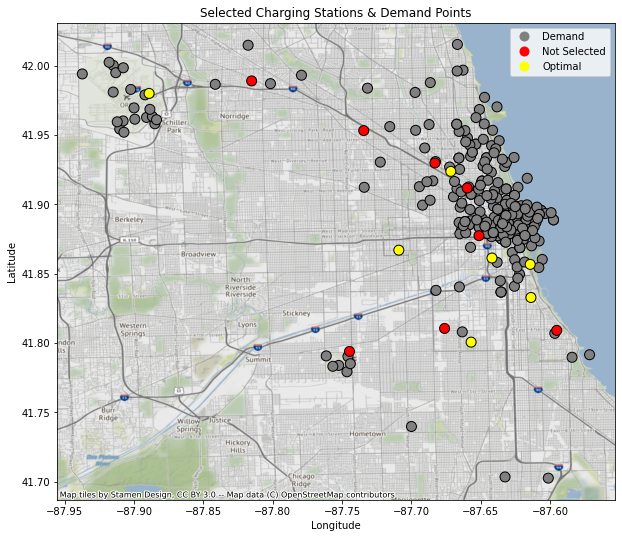

In [110]:
#Visualize Demand Points and Charging Stations
color=['red','blue']
cmap = mcolors.ListedColormap(["grey", "blue", "red", "green", "yellow"])

#Load Coordinates into Geodataframe
plot_df = gpd.GeoDataFrame(
    conc.drop(['lat_i','lon_i'],axis=1), geometry=gpd.points_from_xy(conc['lon_i'], conc['lat_i']))

#Prepare Grid and plot demand & stations
ax = plot_df.plot(figsize=(10,10))
plot_df.plot(ax = ax, marker = 'o',column = 'marker',categorical=True,markersize=100, edgecolor = 'k',legend = True,cmap=cmap)
ctx.add_basemap(ax=ax,zoom=12,crs=4326)

#Description
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Selected Charging Stations & Demand Points")